<a href="https://colab.research.google.com/github/FoleyLab/wptherml/blob/master/PV_Opt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook demonstrates the global optimization of a 2-layer AR coating for a 2 $\mu m$ silicon
solar cell and should reproduce the efficiency reported in Table III ($L = 2$) in "Accelerating the discovery of multi-layer nanostructures with analytic differentiation of the transfer matrix equations" by J. F. Varner, D. Wert, A. Matari, R. Nofal, and J. J. Foley IV.

In [ ]:
!pip install wptherml==1.11b0

  Gradient will be taken with respect to all layers! 
 Temperature not specified!
 Proceeding with default T = 300 K


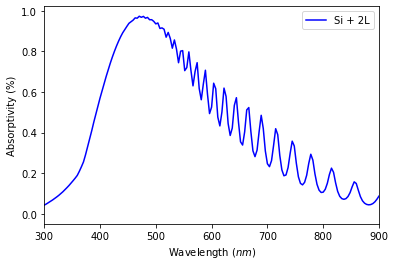

In [2]:
from wptherml.wpml import multilayer
from wptherml.datalib import datalib
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import basinhopping
import numpy as np
import time

### Define a 2 micron silicon slab with a SiO2 and AlN coating...
### we will optimize over the SiO2 and AlN coatings only.
### Si with 2-layer AR coating
dof2_structure = {
        'Material_List' : ['Air', 'AlN','SiO2', 'Si','Air'],
        ### Thicknesses just chosen arbitrarily, replace with "optimal" values
        'Thickness_List': [0, 10.14e-9, 35.70e-9, 2000e-9, 0],
        'Lambda_List': [300e-9, 4000e-9, 1000]
        }

pv_2l = multilayer(dof2_structure)
plt.plot(pv_2l.lambda_array*1e9, pv_2l.emissivity_array, 'blue', label='Si + 2L')
plt.xlim(300,900)
plt.ylabel('Absorptivity (%)')
plt.xlabel('Wavelength ($nm$)')
plt.legend()

In [3]:
pv_2l.pv_conversion_efficiency()

print("  Conversion efficiency of bare Si+2L",pv_2l.conversion_efficiency_val*100)

  Conversion efficiency of bare Si+2L 7.878227632216832


In [ ]:
l1 = np.linspace(1e-9, 400e-9, 10)
l2 = np.linspace(1e-9, 400e-9, 20)

for la in l1:
    for lb in l2:
        pv_2l

In [ ]:

### given an array of thicknesses of the AR layers, update
### the structure and compute its conversion efficiency
def update_multilayer(x):
    for i in range(0,len(x)):
        cc.d[i+1] = x[i]*1e-9
    ### now we have the new structure, update fresnel quantities
    cc.fresnel()
    ### now we have new emissivity, update thermal emission
    cc.pv_conversion_efficiency()

    ### return negative of luminous efficiency
    return -cc.conversion_efficiency_val*100

### given an array of thicknesses of the AR layers, update
### the structure and compute the gradient vector of conversion efficiency wrt AR layer thicknesses
def analytic_grad(x0):
    cur = update_multilayer(x0)
    cc.fresnel_prime()
    cc.pv_conversion_efficiency_prime()
    g = cc.conversion_efficiency_grad
    ### return the negative of the gradient scaled by 10^-9 
    ### will make step-size more reasonable
    return -g*1e-9

### This is a finite-difference version of the gradient
### which may be called by SuperFunc if one wants to compare it
### to analytic_grad
def BuildGradient(x0):
    dim = len(x0)
    h0 = 0.1e-9*np.ones(dim)
    g = np.zeros(dim)
    for i in range(0,dim):
        xpass = np.copy(x0)
        fx = x0[i] + h0[i]
        bx = x0[i] - h0[i]
        xpass[i] = fx
        efx = update_multilayer(xpass)
        xpass[i] = bx
        ebx = update_multilayer(xpass)

        run = 2*h0[i]
        g[i] = (efx-ebx)/run
    return g

### function that gets efficiency and gradient given an array 
### of AR layer thicknesses
def SuperFunc(x):
    en = update_multilayer(x)
    gr = analytic_grad(x)
    return en, gr

### prints efficiency and time
def print_fun(x, f, accepted):
    c_time = time.time()
    print(f,",",c_time)

### called by the basin hopping algorithm to initiate new
### local optimizations
def my_take_step(x):
    xnew = np.copy(x)
    dim = len(xnew)
    for i in range(0,dim):
        rn = 50.*np.abs(np.random.randn())
        xnew[i] = rn
    return xnew

### bounds on basin hopping solutions
class MyBounds(object):
      ### note xmax and xmin need to have as many elements as there are thicknesses that are varied
    def __init__(self, xmax=49.01*np.ones(length), xmin=0.01*np.ones(length)):
        self.xmax = np.array(xmax)
        self.xmin = np.array(xmin)
    def __call__(self, **kwargs):
        x = kwargs["x_new"]
        tmax = bool(np.all(x <= self.xmax))
        tmin = bool(np.all(x >= self.xmin))
        return tmax and tmin

# the bounds for L-BFGS-B updates!
bfgs_xmin = 0.01*np.ones(length)
bfgs_xmax = 49.01*np.ones(length)

# rewrite the bounds in the way required by L-BFGS-B
bfgs_bounds = [(low, high) for low, high in zip(bfgs_xmin, bfgs_xmax)]

### arguments for basin hopping algorithm
minimizer_kwargs = {"method": "L-BFGS-B", "jac": True, "bounds": bfgs_bounds}
mybounds = MyBounds()

### initial guess for AR layer thicknesses!
xs = np.ones(length)*20.

### call basin hopping!
ret = basinhopping(SuperFunc, xs, minimizer_kwargs=minimizer_kwargs, niter=100, take_step=my_take_step, callback=print_fun, accept_test=mybounds)

### print optimimal result!
print(ret.x)
print(update_multilayer(ret.x))

